In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### XGBoost

In [2]:
# classifier
def XGBoostC(train_x, test_x, train_y, test_y, config):
    
    clf = xgb.XGBClassifier(**config, n_jobs = -1, use_label_encoder = False)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    define_predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result
    

# regressor
def XGBoostR(train_x, test_x, train_y, test_y, config):
    
    reg = xgb.XGBRegressor(**config, n_jobs = -1)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result


# classifier for all resampling datasets
def runall_XGBoostC(trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    set_index = list(config.keys())
    judge = set_index[0]

    for i, j in tqdm(enumerate(set_index)):
        print('\n', f'Data{j}:')
        if isinstance(config[judge], dict) :
            best_config = config[j]
        else :
            best_config = config
            
        result = XGBoostC(trainset_x[j], test_x, trainset_y[j], test_y, best_config)    
        table = cf_matrix(result, trainset_y[j])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'data{j}'})

    return table_set
    

# regressor for all resampling datasets
def runall_XGBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = XGBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)     
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
    return pr_dict, table_set

### Optuna

In [3]:
# creator of optuna study for XGBoost
def XGBoost_creator(train_data, mode, num_valid = 5, label = 'GB') :
    
    def objective(trial) :

        param = {
            'eval_metric': trial.suggest_categorical('eval_metric', ['logloss']),
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 11, step = 2),
            'max_depth': trial.suggest_int('max_depth', 3, 18, step = 3),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = XGBoostC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 1
                if recall.values > 0:
                    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                else:
                    fscore = 0
                result_list.append(fscore)

            elif mode == 'R':
                result = XGBoostR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

## 

### Load Data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1368, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1369, 88)  balance ratio: 1.02
Dimension of dataset 7 : (1317, 88)  balance ratio: 1.1
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2226, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2256, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

### Search for Best Hyperparameters

In [33]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = False, 
                                     n_iter = 100, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_XGBoost_6',
                                     creator = XGBoost_creator
                                    )

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-03 17:22:51,841] A new study created in memory with name: no-name-f5a72fe8-a306-4ba5-966f-bc8b7392ec2a


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9670619235836627 
Recall: 0.9569752281616688 
Aging Rate: 0.49478487614080835
Precision: 0.9692101740294511 
Recall: 0.9439374185136897 
Aging Rate: 0.4869621903520209
Precision: 0.9684625492772667 
Recall: 0.9608865710560626 
Aging Rate: 0.49608865710560623
[I 2022-03-03 17:22:54,005] Trial 0 finished with value: 0.9610195637961816 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.3, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.325, 'reg_alpha': 4.563211152342992, 'reg_lambda': 0.05597407174371223}. Best is trial 0 with value: 0.9610195637961816.
Precision: 0.9193121693121693 
Recall: 0.9061277705345502 
Aging Rate: 0.49282920469361147
Precision: 0.9072847682119205 
Recall: 0.8930899608865711 
Aging Rate: 0.4921773142112125
Precision: 0.9125827814569536 
Recall: 0.8983050847457628 
Aging Rate: 0.4921773142112125
[I 2022-03-03 17:22:55,790] Trial 1 finished with value: 0.9060638036887453 and parameters: {'

Precision: 0.990909090909091 
Recall: 0.9947848761408083 
Aging Rate: 0.5019556714471969
Precision: 0.9869281045751634 
Recall: 0.984354628422425 
Aging Rate: 0.49869621903520206
Precision: 0.9756722151088348 
Recall: 0.9934810951760105 
Aging Rate: 0.5091264667535854
[I 2022-03-03 17:23:49,787] Trial 13 finished with value: 0.9876596705853568 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.010627153217666475, 'reg_lambda': 0.010463323702395813}. Best is trial 12 with value: 0.9943519756848822.
Precision: 0.9857697283311773 
Recall: 0.9934810951760105 
Aging Rate: 0.5039113428943938
Precision: 0.9869281045751634 
Recall: 0.984354628422425 
Aging Rate: 0.49869621903520206
Precision: 0.984354628422425 
Recall: 0.984354628422425 
Aging Rate: 0.5
[I 2022-03-03 17:23:57,418] Trial 14 finished with value: 0.9865349015722958 and parameters: {

Precision: 0.98828125 
Recall: 0.9895697522816167 
Aging Rate: 0.500651890482399
Precision: 0.9857142857142858 
Recall: 0.9895697522816167 
Aging Rate: 0.5019556714471969
Precision: 0.9868766404199475 
Recall: 0.9804432855280313 
Aging Rate: 0.49674054758800523
[I 2022-03-03 17:25:09,218] Trial 26 finished with value: 0.9867375939526166 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.018579837138888545, 'reg_lambda': 0.010136019745724605}. Best is trial 22 with value: 0.9943635502730341.
Precision: 0.9921568627450981 
Recall: 0.9895697522816167 
Aging Rate: 0.49869621903520206
Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
[I 2022-03-03 17:25:12,494] Trial 27 finished with value: 0.9910926600303432 and para

Precision: 0.9831824062095731 
Recall: 0.9908735332464146 
Aging Rate: 0.5039113428943938
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
Precision: 0.9908972691807543 
Recall: 0.9934810951760105 
Aging Rate: 0.5013037809647979
[I 2022-03-03 17:26:10,618] Trial 39 finished with value: 0.9906781210781618 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.01008199246023368, 'reg_lambda': 0.20308076800148406}. Best is trial 22 with value: 0.9943635502730341.
Precision: 0.9794344473007712 
Recall: 0.9934810951760105 
Aging Rate: 0.5071707953063885
Precision: 0.9780927835051546 
Recall: 0.9895697522816167 
Aging Rate: 0.5058670143415906
Precision: 0.9832689832689833 
Recall: 0.9960886571056062 
Aging Rate: 0.5065189048239895
[I 2022-03-03 17:26:16,872] Trial 40 finished with value: 0.9866142897300324 and parameters: {'eval_metr

Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
Precision: 0.9896238651102465 
Recall: 0.9947848761408083 
Aging Rate: 0.5026075619295959
Precision: 0.9895561357702349 
Recall: 0.9882659713168188 
Aging Rate: 0.49934810951760106
[I 2022-03-03 17:27:39,994] Trial 52 finished with value: 0.9908834189702206 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.05341889106400168, 'reg_lambda': 0.015890087977178887}. Best is trial 22 with value: 0.9943635502730341.
Precision: 0.9934640522875817 
Recall: 0.9908735332464146 
Aging Rate: 0.49869621903520206
Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
Precision: 0.9870298313878081 
Recall: 0.9921773142112125 
Aging Rate: 0.5026075619295959
[I 2022-03-03 17:27:45,906] Trial 53 finished with value: 0.9908831325193539 and paramete

Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
Precision: 0.983225806451613 
Recall: 0.9934810951760105 
Aging Rate: 0.5052151238591917
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
[I 2022-03-03 17:28:49,507] Trial 65 finished with value: 0.9906820424422876 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.23657707737668873, 'reg_lambda': 0.016116886585013743}. Best is trial 22 with value: 0.9943635502730341.
Precision: 0.9895287958115183 
Recall: 0.9856584093872229 
Aging Rate: 0.4980443285528031
Precision: 0.9831824062095731 
Recall: 0.9908735332464146 
Aging Rate: 0.5039113428943938
Precision: 0.9869791666666666 
Recall: 0.9882659713168188 
Aging Rate: 0.500651890482399
[I 2022-03-03 17:28:58,751] Trial 66 finished with value: 0.9874083158104799 and parameters: {'

Precision: 0.9895561357702349 
Recall: 0.9882659713168188 
Aging Rate: 0.49934810951760106
Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
Precision: 0.9843953185955787 
Recall: 0.9869621903520208 
Aging Rate: 0.5013037809647979
[I 2022-03-03 17:29:50,027] Trial 78 finished with value: 0.9882719097029663 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.16518050625545466, 'reg_lambda': 0.025324296620413595}. Best is trial 22 with value: 0.9943635502730341.
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate: 0.5
Precision: 0.9973890339425587 
Recall: 0.9960886571056062 
Aging Rate: 0.49934810951760106
[I 2022-03-03 17:29:57,503] Trial 79 finished with value: 0.9954337884739606 and parameters: {'eval_metric'

Precision: 0.9869791666666666 
Recall: 0.9882659713168188 
Aging Rate: 0.500651890482399
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
[I 2022-03-03 17:31:24,810] Trial 91 finished with value: 0.9910952114629725 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.01185305235116946, 'reg_lambda': 0.45106667065945166}. Best is trial 79 with value: 0.9954337884739606.
Precision: 0.9806451612903225 
Recall: 0.9908735332464146 
Aging Rate: 0.5052151238591917
Precision: 0.977922077922078 
Recall: 0.9817470664928292 
Aging Rate: 0.5019556714471969
Precision: 0.979381443298969 
Recall: 0.9908735332464146 
Aging Rate: 0.5058670143415906
[I 2022-03-03 17:31:30,538] Trial 92 finished with value: 0.9835525422014064 and 

[I 2022-03-03 17:32:14,665] A new study created in memory with name: no-name-9b77b4a5-4156-4555-82e6-a86ca0dbb55e


Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
[I 2022-03-03 17:32:14,587] Trial 99 finished with value: 0.9928394945276925 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.125, 'reg_alpha': 0.058951271997550535, 'reg_lambda': 0.06272237517070427}. Best is trial 79 with value: 0.9954337884739606.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9705488621151271 
Recall: 0.9666666666666667 
Aging Rate: 0.498
Precision: 0.9496124031007752 
Recall: 0.98 
Aging Rate: 0.516
Precision: 0.963254593175853 
Recall: 0.9786666666666667 
Aging Rate: 0.508
[I 2022-03-03 17:32:17,473] Trial 0 finished with value: 0.9680234248162757 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 5.591075935962873, 'reg_lambda': 0.054053299701346355}. Best is trial 0 with value: 0.9680234248162757.
Precision: 0.9774834437086093 
Recall: 0.984 
Aging Rate: 0.5033333333333333
Precision: 0.9892183288409704 
Recall: 0.9786666666666667 
Aging Rate: 0.49466666666666664
Precision: 0.976158940397351 
Recall: 0.9826666666666667 
Aging Rate: 0.5033333333333333
[I 2022-03-03 17:32:18,775] Trial 1 finished with value: 0.9813490331602432 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.3, 'colsa

Precision: 0.9591567852437418 
Recall: 0.9706666666666667 
Aging Rate: 0.506
[I 2022-03-03 17:32:59,182] Trial 13 finished with value: 0.961221018044038 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'max_depth': 6, 'learning_rate': 0.125, 'reg_alpha': 0.07314900091243395, 'reg_lambda': 0.020869831780463245}. Best is trial 1 with value: 0.9813490331602432.
Precision: 0.9763469119579501 
Recall: 0.9906666666666667 
Aging Rate: 0.5073333333333333
Precision: 0.9748344370860927 
Recall: 0.9813333333333333 
Aging Rate: 0.5033333333333333
Precision: 0.9852941176470589 
Recall: 0.9826666666666667 
Aging Rate: 0.49866666666666665
[I 2022-03-03 17:33:00,834] Trial 14 finished with value: 0.9818354645564971 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.0397361785028676, 'reg_l

Precision: 0.9722589167767504 
Recall: 0.9813333333333333 
Aging Rate: 0.5046666666666667
Precision: 0.9738562091503268 
Recall: 0.9933333333333333 
Aging Rate: 0.51
Precision: 0.974934036939314 
Recall: 0.9853333333333333 
Aging Rate: 0.5053333333333333
[I 2022-03-03 17:33:43,406] Trial 27 finished with value: 0.98012650013283 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.225, 'reg_alpha': 0.15253359383023166, 'reg_lambda': 0.1190893504351603}. Best is trial 20 with value: 0.9849041637559468.
Precision: 0.9762845849802372 
Recall: 0.988 
Aging Rate: 0.506
Precision: 0.9906040268456375 
Recall: 0.984 
Aging Rate: 0.49666666666666665
Precision: 0.9814323607427056 
Recall: 0.9866666666666667 
Aging Rate: 0.5026666666666667
[I 2022-03-03 17:33:50,314] Trial 28 finished with value: 0.9844802929853221 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsamp

Precision: 0.9591029023746702 
Recall: 0.9693333333333334 
Aging Rate: 0.5053333333333333
Precision: 0.9786950732356857 
Recall: 0.98 
Aging Rate: 0.5006666666666667
[I 2022-03-03 17:35:18,774] Trial 40 finished with value: 0.9714405386336421 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.325, 'reg_alpha': 0.016853311503872537, 'reg_lambda': 5.548262638331509}. Best is trial 30 with value: 0.9849429156757982.
Precision: 0.9813829787234043 
Recall: 0.984 
Aging Rate: 0.5013333333333333
Precision: 0.9762532981530343 
Recall: 0.9866666666666667 
Aging Rate: 0.5053333333333333
Precision: 0.9815059445178336 
Recall: 0.9906666666666667 
Aging Rate: 0.5046666666666667
[I 2022-03-03 17:35:25,344] Trial 41 finished with value: 0.9833957125357835 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_

Precision: 0.9853917662682603 
Recall: 0.9893333333333333 
Aging Rate: 0.502
[I 2022-03-03 17:36:33,249] Trial 53 finished with value: 0.9851192376632062 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.042460036525049615, 'reg_lambda': 4.952998129614133}. Best is trial 51 with value: 0.9893621038946993.
Precision: 0.9749670619235836 
Recall: 0.9866666666666667 
Aging Rate: 0.506
Precision: 0.9747340425531915 
Recall: 0.9773333333333334 
Aging Rate: 0.5013333333333333
Precision: 0.9710526315789474 
Recall: 0.984 
Aging Rate: 0.5066666666666667
[I 2022-03-03 17:36:40,062] Trial 54 finished with value: 0.9780991253055052 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.04355494915168635, 're

Precision: 0.9868073878627969 
Recall: 0.9973333333333333 
Aging Rate: 0.5053333333333333
Precision: 0.9776315789473684 
Recall: 0.9906666666666667 
Aging Rate: 0.5066666666666667
[I 2022-03-03 17:37:43,960] Trial 66 finished with value: 0.9869485575685415 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.125, 'reg_alpha': 0.19686560399171404, 'reg_lambda': 0.027836699391709237}. Best is trial 51 with value: 0.9893621038946993.
Precision: 0.9866844207723036 
Recall: 0.988 
Aging Rate: 0.5006666666666667
Precision: 0.988031914893617 
Recall: 0.9906666666666667 
Aging Rate: 0.5013333333333333
Precision: 0.9867021276595744 
Recall: 0.9893333333333333 
Aging Rate: 0.5013333333333333
[I 2022-03-03 17:37:47,131] Trial 67 finished with value: 0.988235095821605 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_we

Precision: 0.9867021276595744 
Recall: 0.9893333333333333 
Aging Rate: 0.5013333333333333
Precision: 0.9853723404255319 
Recall: 0.988 
Aging Rate: 0.5013333333333333
[I 2022-03-03 17:38:30,102] Trial 79 finished with value: 0.9875880199816102 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.025, 'reg_alpha': 0.9757228230568704, 'reg_lambda': 0.021458803702924103}. Best is trial 68 with value: 0.989806416813687.
Precision: 0.9556714471968709 
Recall: 0.9773333333333334 
Aging Rate: 0.5113333333333333
Precision: 0.9673629242819843 
Recall: 0.988 
Aging Rate: 0.5106666666666667
Precision: 0.9731543624161074 
Recall: 0.9666666666666667 
Aging Rate: 0.49666666666666665
[I 2022-03-03 17:38:34,019] Trial 80 finished with value: 0.9712844133600322 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 11, '

Precision: 0.9815546772068511 
Recall: 0.9933333333333333 
Aging Rate: 0.506
Precision: 0.9907161803713528 
Recall: 0.996 
Aging Rate: 0.5026666666666667
Precision: 0.9893758300132802 
Recall: 0.9933333333333333 
Aging Rate: 0.502
[I 2022-03-03 17:39:34,636] Trial 92 finished with value: 0.9907035253173323 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.1945990083092175, 'reg_lambda': 0.018216185745235213}. Best is trial 86 with value: 0.9917950301674973.
Precision: 0.9946595460614153 
Recall: 0.9933333333333333 
Aging Rate: 0.49933333333333335
Precision: 0.9906040268456375 
Recall: 0.984 
Aging Rate: 0.49666666666666665
Precision: 0.992 
Recall: 0.992 
Aging Rate: 0.5
[I 2022-03-03 17:39:39,293] Trial 93 finished with value: 0.9910956557437399 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_

[I 2022-03-03 17:40:06,594] A new study created in memory with name: no-name-653484a3-f694-49a4-a43b-ea1c583a8aad


Precision: 0.9865951742627346 
Recall: 0.9813333333333333 
Aging Rate: 0.49733333333333335
[I 2022-03-03 17:40:06,485] Trial 99 finished with value: 0.9857871581901619 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.125, 'reg_alpha': 0.8505759278287994, 'reg_lambda': 0.02376145391460674}. Best is trial 86 with value: 0.9917950301674973.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9945652173913043 
Recall: 0.9644268774703557 
Aging Rate: 0.48484848484848486
Precision: 1.0 
Recall: 0.9591567852437418 
Aging Rate: 0.4795783926218709
Precision: 1.0 
Recall: 0.9578392621870883 
Aging Rate: 0.47891963109354413
[I 2022-03-03 17:40:09,679] Trial 0 finished with value: 0.9789608500262951 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.225, 'reg_alpha': 3.429476089760146, 'reg_lambda': 0.20220481149320377}. Best is trial 0 with value: 0.9789608500262951.
Precision: 0.9985549132947977 
Recall: 0.9104084321475626 
Aging Rate: 0.45586297760210803
Precision: 0.9971469329529244 
Recall: 0.9209486166007905 
Aging Rate: 0.46179183135704877
Precision: 1.0 
Recall: 0.9367588932806324 
Aging Rate: 0.4683794466403162
[I 2022-03-03 17:40:10,740] Trial 1 finished with value: 0.9591092579701556 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100

Precision: 0.994572591587517 
Recall: 0.9657444005270093 
Aging Rate: 0.4855072463768116
Precision: 0.9973226238286479 
Recall: 0.9815546772068511 
Aging Rate: 0.49209486166007904
Precision: 0.9986577181208054 
Recall: 0.9802371541501976 
Aging Rate: 0.49077733860342554
[I 2022-03-03 17:41:14,706] Trial 13 finished with value: 0.9862280187350371 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.1483518777141676, 'reg_lambda': 1.7751808117113346}. Best is trial 10 with value: 0.9882950709899899.
Precision: 0.9946164199192463 
Recall: 0.9736495388669302 
Aging Rate: 0.4894598155467721
Precision: 0.9973262032085561 
Recall: 0.9828722002635046 
Aging Rate: 0.4927536231884058
Precision: 1.0 
Recall: 0.9828722002635046 
Aging Rate: 0.4914361001317523
[I 2022-03-03 17:41:23,428] Trial 14 finished with value: 0.9884766270243587 and parameters: {'eval_metric': '

Precision: 0.9973297730307076 
Recall: 0.9841897233201581 
Aging Rate: 0.49341238471673254
Precision: 0.9868421052631579 
Recall: 0.9881422924901185 
Aging Rate: 0.5006587615283268
Precision: 0.9946524064171123 
Recall: 0.9802371541501976 
Aging Rate: 0.4927536231884058
[I 2022-03-03 17:42:39,177] Trial 26 finished with value: 0.9885333737157277 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.010428043603546037, 'reg_lambda': 0.815459064775182}. Best is trial 20 with value: 0.9905165316081718.
Precision: 0.9986282578875172 
Recall: 0.9591567852437418 
Aging Rate: 0.48023715415019763
Precision: 0.9920106524633822 
Recall: 0.9815546772068511 
Aging Rate: 0.49472990777338605
Precision: 1.0 
Recall: 0.9683794466403162 
Aging Rate: 0.4841897233201581
[I 2022-03-03 17:42:43,553] Trial 27 finished with value: 0.9830617778384063 and parameters:

Precision: 0.9973404255319149 
Recall: 0.9881422924901185 
Aging Rate: 0.49538866930171277
Precision: 0.9946018893387314 
Recall: 0.9710144927536232 
Aging Rate: 0.4881422924901186
Precision: 0.9973509933774835 
Recall: 0.9920948616600791 
Aging Rate: 0.497364953886693
[I 2022-03-03 17:44:00,678] Trial 39 finished with value: 0.9900342345865628 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.017757577962704853, 'reg_lambda': 0.20175615505856462}. Best is trial 36 with value: 0.9918244277390933.
Precision: 0.9973082099596231 
Recall: 0.9762845849802372 
Aging Rate: 0.4894598155467721
Precision: 0.9947159841479525 
Recall: 0.9920948616600791 
Aging Rate: 0.4986824769433465
Precision: 0.9946808510638298 
Recall: 0.9855072463768116 
Aging Rate: 0.49538866930171277
[I 2022-03-03 17:44:12,729] Trial 40 finished with value: 0.9900536380580838

Precision: 1.0 
Recall: 0.9789196310935442 
Aging Rate: 0.4894598155467721
Precision: 0.9960106382978723 
Recall: 0.9868247694334651 
Aging Rate: 0.49538866930171277
Precision: 0.9946380697050938 
Recall: 0.9776021080368906 
Aging Rate: 0.4914361001317523
[I 2022-03-03 17:46:40,501] Trial 52 finished with value: 0.9889301581511866 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.025, 'reg_alpha': 0.023046379452316343, 'reg_lambda': 0.09401415016901496}. Best is trial 36 with value: 0.9918244277390933.
Precision: 0.9986684420772304 
Recall: 0.9881422924901185 
Aging Rate: 0.49472990777338605
Precision: 0.9880636604774535 
Recall: 0.9815546772068511 
Aging Rate: 0.49670619235836627
Precision: 0.9959183673469387 
Recall: 0.9644268774703557 
Aging Rate: 0.4841897233201581
[I 2022-03-03 17:46:54,541] Trial 53 finished with value: 0.986031858635363 and parameters: {'eval_metr

Precision: 0.9959893048128342 
Recall: 0.9815546772068511 
Aging Rate: 0.4927536231884058
Precision: 0.9945652173913043 
Recall: 0.9644268774703557 
Aging Rate: 0.48484848484848486
Precision: 0.9881578947368421 
Recall: 0.9894598155467721 
Aging Rate: 0.5006587615283268
[I 2022-03-03 17:48:59,737] Trial 65 finished with value: 0.985597316843487 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.4123625910301919, 'reg_lambda': 0.11569090022859276}. Best is trial 36 with value: 0.9918244277390933.
Precision: 0.9973333333333333 
Recall: 0.9855072463768116 
Aging Rate: 0.49407114624505927
Precision: 0.9959946595460614 
Recall: 0.9828722002635046 
Aging Rate: 0.49341238471673254
Precision: 0.992 
Recall: 0.9802371541501976 
Aging Rate: 0.49407114624505927
[I 2022-03-03 17:49:08,854] Trial 66 finished with value: 0.9889528142081785 and paramete

Precision: 0.9986431478968792 
Recall: 0.9696969696969697 
Aging Rate: 0.4855072463768116
Precision: 0.9973154362416108 
Recall: 0.9789196310935442 
Aging Rate: 0.49077733860342554
Precision: 0.9960159362549801 
Recall: 0.9881422924901185 
Aging Rate: 0.49604743083003955
[I 2022-03-03 17:52:02,075] Trial 78 finished with value: 0.988017542069482 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.225, 'reg_alpha': 0.013199172202327577, 'reg_lambda': 0.23099263617073812}. Best is trial 36 with value: 0.9918244277390933.
Precision: 0.9959677419354839 
Recall: 0.9762845849802372 
Aging Rate: 0.4901185770750988
Precision: 0.9933862433862434 
Recall: 0.9894598155467721 
Aging Rate: 0.4980237154150198
Precision: 0.9986684420772304 
Recall: 0.9881422924901185 
Aging Rate: 0.49472990777338605
[I 2022-03-03 17:52:10,962] Trial 79 finished with value: 0.9902748564898921 and paramete

Precision: 0.9946737683089214 
Recall: 0.9841897233201581 
Aging Rate: 0.49472990777338605
Precision: 0.9946737683089214 
Recall: 0.9841897233201581 
Aging Rate: 0.49472990777338605
Precision: 0.9919463087248322 
Recall: 0.9736495388669302 
Aging Rate: 0.49077733860342554
[I 2022-03-03 17:54:24,951] Trial 91 finished with value: 0.9871735709924381 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.04049679560103756, 'reg_lambda': 0.5373320497610354}. Best is trial 83 with value: 0.9927100948042229.
Precision: 0.99734395750332 
Recall: 0.9894598155467721 
Aging Rate: 0.49604743083003955
Precision: 0.9919246298788694 
Recall: 0.9710144927536232 
Aging Rate: 0.4894598155467721
Precision: 0.9973154362416108 
Recall: 0.9789196310935442 
Aging Rate: 0.49077733860342554
[I 2022-03-03 17:54:39,801] Trial 92 finished with value: 0.9875921157870285

[I 2022-03-03 17:56:02,533] A new study created in memory with name: no-name-517e9488-bdb2-4488-a5b8-a5dd38774f89


Precision: 0.9946595460614153 
Recall: 0.9815546772068511 
Aging Rate: 0.49341238471673254
[I 2022-03-03 17:56:02,392] Trial 99 finished with value: 0.984685565389844 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.014814754990956086, 'reg_lambda': 0.2770651669282137}. Best is trial 83 with value: 0.9927100948042229.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9800266311584553 
Recall: 0.968421052631579 
Aging Rate: 0.49407894736842106
Precision: 0.9879679144385026 
Recall: 0.9723684210526315 
Aging Rate: 0.4921052631578947
Precision: 0.9799732977303071 
Recall: 0.9657894736842105 
Aging Rate: 0.49276315789473685
[I 2022-03-03 17:56:15,335] Trial 0 finished with value: 0.9757083559848794 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'max_depth': 12, 'learning_rate': 0.275, 'reg_alpha': 8.214410463890719, 'reg_lambda': 1.044430832299557}. Best is trial 0 with value: 0.9757083559848794.
Precision: 0.9866666666666667 
Recall: 0.9736842105263158 
Aging Rate: 0.4934210526315789
Precision: 0.9841897233201581 
Recall: 0.9828947368421053 
Aging Rate: 0.4993421052631579
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2022-03-03 17:56:31,395] Trial 1 finished with value: 0.9845910880168058 and parameters: {'eval

Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9812834224598931 
Recall: 0.9657894736842105 
Aging Rate: 0.4921052631578947
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
[I 2022-03-03 17:57:19,368] Trial 13 finished with value: 0.9814393872854709 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.048153810756304434, 'reg_lambda': 0.10082251770117986}. Best is trial 2 with value: 0.9876448996323527.
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
[I 2022-03-03 17:57:21,404] Trial 14 finished with value: 0.9889671443755329 and parameters:

Precision: 0.9894179894179894 
Recall: 0.9842105263157894 
Aging Rate: 0.49736842105263157
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
[I 2022-03-03 17:59:18,604] Trial 26 finished with value: 0.9881018979688944 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.21071957874700192, 'reg_lambda': 0.24257847584865977}. Best is trial 23 with value: 0.9916258593289946.
Precision: 0.9854689564068693 
Recall: 0.9815789473684211 
Aging Rate: 0.4980263157894737
Precision: 0.9880952380952381 
Recall: 0.9828947368421053 
Aging Rate: 0.49736842105263157
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
[I 2022-03-03 17:59:26,701] Trial 27 finished with value: 0.9850489486605959 and paramete

Precision: 0.9880478087649402 
Recall: 0.9789473684210527 
Aging Rate: 0.4953947368421053
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9893048128342246 
Recall: 0.9736842105263158 
Aging Rate: 0.4921052631578947
[I 2022-03-03 18:00:49,084] Trial 39 finished with value: 0.9849895131906372 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.225, 'reg_alpha': 0.0793124772558082, 'reg_lambda': 6.783483005005697}. Best is trial 23 with value: 0.9916258593289946.
Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9853528628495339 
Recall: 0.9736842105263158 
Aging Rate: 0.49407894736842106
Precision: 0.9881422924901185 
Recall: 0.9868421052631579 
Aging Rate: 0.4993421052631579
[I 2022-03-03 18:00:54,916] Trial 40 finished with value: 0.9836938389130928 and parameters: 

Precision: 0.9880794701986755 
Recall: 0.9815789473684211 
Aging Rate: 0.4967105263157895
Precision: 0.9919354838709677 
Recall: 0.9710526315789474 
Aging Rate: 0.48947368421052634
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
[I 2022-03-03 18:01:56,907] Trial 52 finished with value: 0.9840764682277885 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 1.1185936860365706, 'reg_lambda': 3.172863306079332}. Best is trial 23 with value: 0.9916258593289946.
Precision: 0.9907651715039578 
Recall: 0.9881578947368421 
Aging Rate: 0.4986842105263158
Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9959514170040485 
Recall: 0.9710526315789474 
Aging Rate: 0.4875
[I 2022-03-03 18:02:03,354] Trial 53 finished with value: 0.9856367376178815 and parameters: {'eval_metric': 'logloss', '

Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9880794701986755 
Recall: 0.9815789473684211 
Aging Rate: 0.4967105263157895
[I 2022-03-03 18:03:00,135] Trial 65 finished with value: 0.9876700051098851 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.125, 'reg_alpha': 0.9809733534897953, 'reg_lambda': 0.0494741717764283}. Best is trial 23 with value: 0.9916258593289946.
Precision: 0.9840848806366048 
Recall: 0.9763157894736842 
Aging Rate: 0.49605263157894736
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
[I 2022-03-03 18:03:07,030] Trial 66 finished with value: 0.9849984990421831 and parameters: {

Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
Precision: 0.9907651715039578 
Recall: 0.9881578947368421 
Aging Rate: 0.4986842105263158
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2022-03-03 18:04:24,427] Trial 78 finished with value: 0.9874447405260094 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.056573694407517354, 'reg_lambda': 1.8914832031399142}. Best is trial 23 with value: 0.9916258593289946.
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.9986772486772487 
Recall: 0.993421052631579 
Aging Rate: 0.49736842105263157
[I 2022-03-03 18:04:30,494] Trial 79 finished with value: 0.9916125247980431 and parameters

Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9854689564068693 
Recall: 0.9815789473684211 
Aging Rate: 0.4980263157894737
Precision: 0.9907407407407407 
Recall: 0.9855263157894737 
Aging Rate: 0.49736842105263157
[I 2022-03-03 18:05:39,588] Trial 91 finished with value: 0.986346308140588 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.15095677241461453, 'reg_lambda': 1.600169020665611}. Best is trial 23 with value: 0.9916258593289946.
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9894319682959049 
Recall: 0.9855263157894737 
Aging Rate: 0.4980263157894737
Precision: 0.992 
Recall: 0.9789473684210527 
Aging Rate: 0.4934210526315789
[I 2022-03-03 18:05:45,198] Trial 92 finished with value: 0.9869845174997688 and parameters: {'eval_metric

[I 2022-03-03 18:06:41,875] A new study created in memory with name: no-name-3717e329-3ee8-43cb-bdc7-471ed3dc9776


Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
[I 2022-03-03 18:06:41,797] Trial 99 finished with value: 0.988319326274545 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.036255744995758385, 'reg_lambda': 2.4673357167833996}. Best is trial 23 with value: 0.9916258593289946.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9593175853018373 
Recall: 0.9682119205298013 
Aging Rate: 0.502970297029703
Precision: 0.9639519359145527 
Recall: 0.9562913907284768 
Aging Rate: 0.49438943894389437
Precision: 0.9569190600522193 
Recall: 0.9708609271523179 
Aging Rate: 0.5056105610561056
[I 2022-03-03 18:06:43,436] Trial 0 finished with value: 0.9625633980799443 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 9, 'max_depth': 12, 'learning_rate': 0.275, 'reg_alpha': 0.06161294095372001, 'reg_lambda': 0.20839076619377137}. Best is trial 0 with value: 0.9625633980799443.
Precision: 0.9790849673202614 
Recall: 0.9920529801324504 
Aging Rate: 0.504950495049505
Precision: 0.9893617021276596 
Recall: 0.9854304635761589 
Aging Rate: 0.49636963696369635
Precision: 0.9815303430079155 
Recall: 0.9854304635761589 
Aging Rate: 0.5003300330033004
[I 2022-03-03 18:06:46,408] Trial 1 finished with value: 0.9854650074484946 and parameters: {'e

Precision: 0.9829842931937173 
Recall: 0.9947019867549669 
Aging Rate: 0.5042904290429043
Precision: 0.988110964332893 
Recall: 0.990728476821192 
Aging Rate: 0.4996699669966997
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
[I 2022-03-03 18:07:16,781] Trial 13 finished with value: 0.9907540671009016 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.325, 'reg_alpha': 0.09174070668629945, 'reg_lambda': 1.6615824147211826}. Best is trial 6 with value: 0.9911889066890774.
Precision: 0.9829396325459318 
Recall: 0.9920529801324504 
Aging Rate: 0.502970297029703
Precision: 0.988173455978975 
Recall: 0.9960264900662251 
Aging Rate: 0.5023102310231023
Precision: 0.9881422924901185 
Recall: 0.9933774834437086 
Aging Rate: 0.500990099009901
[I 2022-03-03 18:07:19,905] Trial 14 finished with value: 0.9901042283782674 and parameters: {'eval_m

Precision: 0.9829172141918529 
Recall: 0.990728476821192 
Aging Rate: 0.5023102310231023
Precision: 0.9907161803713528 
Recall: 0.9894039735099338 
Aging Rate: 0.4976897689768977
Precision: 0.9841897233201581 
Recall: 0.9894039735099338 
Aging Rate: 0.500990099009901
[I 2022-03-03 18:07:52,503] Trial 26 finished with value: 0.9878856634599317 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 7, 'max_depth': 18, 'learning_rate': 0.325, 'reg_alpha': 0.5596124743962075, 'reg_lambda': 1.0930524298961288}. Best is trial 16 with value: 0.992524184350818.
Precision: 0.9853333333333333 
Recall: 0.9788079470198675 
Aging Rate: 0.49504950495049505
Precision: 0.9803407601572739 
Recall: 0.990728476821192 
Aging Rate: 0.5036303630363036
Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
[I 2022-03-03 18:07:53,599] Trial 27 finished with value: 0.9865470077543973 and parameters: {'eval

Precision: 0.9801849405548216 
Recall: 0.9827814569536424 
Aging Rate: 0.4996699669966997
Precision: 0.9854689564068693 
Recall: 0.9880794701986755 
Aging Rate: 0.4996699669966997
Precision: 0.9829172141918529 
Recall: 0.990728476821192 
Aging Rate: 0.5023102310231023
[I 2022-03-03 18:08:29,767] Trial 39 finished with value: 0.9850204520389217 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.325, 'reg_alpha': 5.653983025244575, 'reg_lambda': 0.5905249098859388}. Best is trial 16 with value: 0.992524184350818.
Precision: 0.9802371541501976 
Recall: 0.9854304635761589 
Aging Rate: 0.500990099009901
Precision: 0.98046875 
Recall: 0.9973509933774835 
Aging Rate: 0.5069306930693069
Precision: 0.9802110817941952 
Recall: 0.9841059602649007 
Aging Rate: 0.5003300330033004
[I 2022-03-03 18:08:31,927] Trial 40 finished with value: 0.9846064760631417 and parameters: {'eval_metric'

Precision: 0.9894736842105263 
Recall: 0.9960264900662251 
Aging Rate: 0.5016501650165016
Precision: 0.9881266490765171 
Recall: 0.9920529801324504 
Aging Rate: 0.5003300330033004
Precision: 0.9881578947368421 
Recall: 0.9947019867549669 
Aging Rate: 0.5016501650165016
[I 2022-03-03 18:08:54,694] Trial 52 finished with value: 0.9914147792836125 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.364935106998265, 'reg_lambda': 0.4312439988327851}. Best is trial 16 with value: 0.992524184350818.
Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
Precision: 0.9867899603698811 
Recall: 0.9894039735099338 
Aging Rate: 0.4996699669966997
Precision: 0.9934036939313984 
Recall: 0.9973509933774835 
Aging Rate: 0.5003300330033004
[I 2022-03-03 18:08:55,831] Trial 53 finished with value: 0.9920532327555184 and parameters: {'eval_metric': 

Precision: 0.9934036939313984 
Recall: 0.9973509933774835 
Aging Rate: 0.5003300330033004
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
[I 2022-03-03 18:09:16,605] Trial 65 finished with value: 0.993823947744587 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.275, 'reg_alpha': 0.17284602582648953, 'reg_lambda': 1.7817739393721843}. Best is trial 65 with value: 0.993823947744587.
Precision: 0.9946808510638298 
Recall: 0.990728476821192 
Aging Rate: 0.49636963696369635
Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
[I 2022-03-03 18:09:18,039] Trial 66 finished with value: 0.9924979660435396 and parameters: {'e

Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
[I 2022-03-03 18:09:34,543] Trial 78 finished with value: 0.9924950389351609 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.24101021815383417, 'reg_lambda': 1.6934688611785162}. Best is trial 65 with value: 0.993823947744587.
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
Precision: 0.9933949801849405 
Recall: 0.9960264900662251 
Aging Rate: 0.4996699669966997
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
[I 2022-03-03 18:09:35,840] Trial 79 finished with value: 0.9938216109807781 and parameters: {'eval_m

Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9946808510638298 
Recall: 0.990728476821192 
Aging Rate: 0.49636963696369635
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
[I 2022-03-03 18:09:59,571] Trial 91 finished with value: 0.9927074701082366 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.24605624472857499, 'reg_lambda': 1.7860447307747598}. Best is trial 82 with value: 0.994701985012275.
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
Precision: 0.9894039735099338 
Recall: 0.9894039735099338 
Aging Rate: 0.49834983498349833
Precision: 0.9868073878627969 
Recall: 0.990728476821192 
Aging Rate: 0.5003300330033004
[I 2022-03-03 18:10:00,866] Trial 92 finished with value: 0.990518087279999 and parameters: {'ev

[I 2022-03-03 18:10:09,381] A new study created in memory with name: no-name-0800d7ac-fa8c-4570-a87a-ea5b83a06cdf


Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
[I 2022-03-03 18:10:09,303] Trial 99 finished with value: 0.9913920433378185 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.2773556558857312, 'reg_lambda': 1.0192490390475664}. Best is trial 82 with value: 0.994701985012275.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9348404255319149 
Recall: 0.9373333333333334 
Aging Rate: 0.49801324503311256
Precision: 0.9444444444444444 
Recall: 0.952 
Aging Rate: 0.5006622516556292
Precision: 0.9252948885976409 
Recall: 0.9413333333333334 
Aging Rate: 0.5052980132450331
[I 2022-03-03 18:10:11,462] Trial 0 finished with value: 0.9391791997391454 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'max_depth': 6, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.8510537875685252, 'reg_lambda': 8.052795490690674}. Best is trial 0 with value: 0.9391791997391454.
Precision: 0.9772423025435074 
Recall: 0.9733333333333334 
Aging Rate: 0.4947019867549669
Precision: 0.9747340425531915 
Recall: 0.9773333333333334 
Aging Rate: 0.49801324503311256
Precision: 0.9658344283837057 
Recall: 0.98 
Aging Rate: 0.5039735099337749
[I 2022-03-03 18:10:13,587] Trial 1 finished with value: 0.9747271701373065 and parameters: {'eval_metric': '

Precision: 0.9775132275132276 
Recall: 0.9853333333333333 
Aging Rate: 0.5006622516556292
Precision: 0.9852744310575636 
Recall: 0.9813333333333333 
Aging Rate: 0.4947019867549669
Precision: 0.9828269484808454 
Recall: 0.992 
Aging Rate: 0.5013245033112583
[I 2022-03-03 18:11:06,121] Trial 13 finished with value: 0.9840332685322983 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0348284101395407, 'reg_lambda': 0.027208316545552193}. Best is trial 11 with value: 0.9853199774391269.
Precision: 0.976 
Recall: 0.976 
Aging Rate: 0.4966887417218543
Precision: 0.9634464751958225 
Recall: 0.984 
Aging Rate: 0.5072847682119205
Precision: 0.9837837837837838 
Recall: 0.9706666666666667 
Aging Rate: 0.4900662251655629
[I 2022-03-03 18:11:12,578] Trial 14 finished with value: 0.9755986612597617 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'su

Precision: 0.9788639365918098 
Recall: 0.988 
Aging Rate: 0.5013245033112583
Precision: 0.9773635153129161 
Recall: 0.9786666666666667 
Aging Rate: 0.49735099337748345
Precision: 0.9708222811671088 
Recall: 0.976 
Aging Rate: 0.49933774834437084
[I 2022-03-03 18:12:21,151] Trial 26 finished with value: 0.9782765540162198 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 9, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.25324343959230394, 'reg_lambda': 0.01422946107869546}. Best is trial 25 with value: 0.9857658247051236.
Precision: 0.9725130890052356 
Recall: 0.9906666666666667 
Aging Rate: 0.5059602649006623
Precision: 0.9789473684210527 
Recall: 0.992 
Aging Rate: 0.5033112582781457
Precision: 0.9827127659574468 
Recall: 0.9853333333333333 
Aging Rate: 0.49801324503311256
[I 2022-03-03 18:12:27,929] Trial 27 finished with value: 0.9836525710069189 and parameters: {'eval_metric': 'logl

Precision: 0.9802631578947368 
Recall: 0.9933333333333333 
Aging Rate: 0.5033112582781457
Precision: 0.980106100795756 
Recall: 0.9853333333333333 
Aging Rate: 0.49933774834437084
Precision: 0.9776021080368906 
Recall: 0.9893333333333333 
Aging Rate: 0.5026490066225165
[I 2022-03-03 18:13:23,845] Trial 39 finished with value: 0.9843001565855753 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.14422024342376966, 'reg_lambda': 0.1893530250143815}. Best is trial 34 with value: 0.9864791318300075.
Precision: 0.9735799207397622 
Recall: 0.9826666666666667 
Aging Rate: 0.5013245033112583
Precision: 0.9774834437086093 
Recall: 0.984 
Aging Rate: 0.5
Precision: 0.9734748010610079 
Recall: 0.9786666666666667 
Aging Rate: 0.49933774834437084
[I 2022-03-03 18:13:29,566] Trial 40 finished with value: 0.9782989721927408 and parameters: {'eval_metric'

Precision: 0.9906417112299465 
Recall: 0.988 
Aging Rate: 0.495364238410596
Precision: 0.9788639365918098 
Recall: 0.988 
Aging Rate: 0.5013245033112583
Precision: 0.9879679144385026 
Recall: 0.9853333333333333 
Aging Rate: 0.495364238410596
[I 2022-03-03 18:15:11,207] Trial 52 finished with value: 0.9864595690368252 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.5049647511567152, 'reg_lambda': 0.6365648549976292}. Best is trial 46 with value: 0.9878336659162011.
Precision: 0.9827127659574468 
Recall: 0.9853333333333333 
Aging Rate: 0.49801324503311256
Precision: 0.9773333333333334 
Recall: 0.9773333333333334 
Aging Rate: 0.4966887417218543
Precision: 0.9801849405548216 
Recall: 0.9893333333333333 
Aging Rate: 0.5013245033112583
[I 2022-03-03 18:15:18,375] Trial 53 finished with value: 0.9820308427024922 and parameters: {'eval_metric':

Precision: 0.9801324503311258 
Recall: 0.9866666666666667 
Aging Rate: 0.5
Precision: 0.9827814569536424 
Recall: 0.9893333333333333 
Aging Rate: 0.5
Precision: 0.9775429326287979 
Recall: 0.9866666666666667 
Aging Rate: 0.5013245033112583
[I 2022-03-03 18:16:39,198] Trial 65 finished with value: 0.9838396085892267 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.49955462011865565, 'reg_lambda': 0.7645983905512455}. Best is trial 46 with value: 0.9878336659162011.
Precision: 0.9827357237715804 
Recall: 0.9866666666666667 
Aging Rate: 0.4986754966887417
Precision: 0.9774834437086093 
Recall: 0.984 
Aging Rate: 0.5
Precision: 0.9801324503311258 
Recall: 0.9866666666666667 
Aging Rate: 0.5
[I 2022-03-03 18:16:46,398] Trial 66 finished with value: 0.9829389578171085 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample'

Precision: 0.994579945799458 
Recall: 0.9786666666666667 
Aging Rate: 0.48874172185430464
Precision: 0.9801324503311258 
Recall: 0.9866666666666667 
Aging Rate: 0.5
Precision: 0.9747675962815405 
Recall: 0.9786666666666667 
Aging Rate: 0.4986754966887417
[I 2022-03-03 18:18:06,488] Trial 78 finished with value: 0.9822203614300591 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.37787807527331874, 'reg_lambda': 4.904635000028892}. Best is trial 46 with value: 0.9878336659162011.
Precision: 0.9787516600265604 
Recall: 0.9826666666666667 
Aging Rate: 0.4986754966887417
Precision: 0.9828722002635046 
Recall: 0.9946666666666667 
Aging Rate: 0.5026490066225165
Precision: 0.9866310160427807 
Recall: 0.984 
Aging Rate: 0.495364238410596
[I 2022-03-03 18:18:11,564] Trial 79 finished with value: 0.9849177563077721 and parameters: {'eval_metric': 'logloss', 'n_e

Precision: 0.9827586206896551 
Recall: 0.988 
Aging Rate: 0.49933774834437084
Precision: 0.9893617021276596 
Recall: 0.992 
Aging Rate: 0.49801324503311256
Precision: 0.9826897470039947 
Recall: 0.984 
Aging Rate: 0.49735099337748345
[I 2022-03-03 18:19:36,666] Trial 91 finished with value: 0.986465290669372 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.5084491250589753, 'reg_lambda': 2.342399528223192}. Best is trial 85 with value: 0.9884480375692318.
Precision: 0.9919463087248322 
Recall: 0.9853333333333333 
Aging Rate: 0.49337748344370863
Precision: 0.9879356568364611 
Recall: 0.9826666666666667 
Aging Rate: 0.49403973509933774
Precision: 0.9879518072289156 
Recall: 0.984 
Aging Rate: 0.4947019867549669
[I 2022-03-03 18:19:44,899] Trial 92 finished with value: 0.9866316080255468 and parameters: {'eval_metric': 'logloss', 'n_estimat

[I 2022-03-03 18:20:41,942] A new study created in memory with name: no-name-1ddb5028-407c-4915-b5b1-845b67b61203


Precision: 0.9840848806366048 
Recall: 0.9893333333333333 
Aging Rate: 0.49933774834437084
[I 2022-03-03 18:20:41,864] Trial 99 finished with value: 0.986701986566843 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.692566482722104, 'reg_lambda': 4.045213623737968}. Best is trial 85 with value: 0.9884480375692318.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9985185185185185 
Recall: 0.9739884393063584 
Aging Rate: 0.46487603305785125
Precision: 0.9924585218702866 
Recall: 0.9508670520231214 
Aging Rate: 0.45661157024793386
Precision: 0.9955290611028316 
Recall: 0.9653179190751445 
Aging Rate: 0.4621212121212121
[I 2022-03-03 18:20:43,688] Trial 0 finished with value: 0.9791698062835575 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.275, 'reg_alpha': 0.012879506364343379, 'reg_lambda': 0.018902627433810534}. Best is trial 0 with value: 0.9791698062835575.
Precision: 0.9984567901234568 
Recall: 0.934971098265896 
Aging Rate: 0.4462809917355372
Precision: 1.0 
Recall: 0.9552023121387283 
Aging Rate: 0.45523415977961434
Precision: 0.9939301972685888 
Recall: 0.9465317919075145 
Aging Rate: 0.45385674931129477
[I 2022-03-03 18:20:44,302] Trial 1 finished with value: 0.9708039013457453 and parameters: {'eval_metric

Precision: 0.9911634756995582 
Recall: 0.9725433526011561 
Aging Rate: 0.46763085399449034
Precision: 0.9970326409495549 
Recall: 0.9710982658959537 
Aging Rate: 0.4641873278236915
Precision: 0.9925149700598802 
Recall: 0.958092485549133 
Aging Rate: 0.46005509641873277
[I 2022-03-03 18:21:20,951] Trial 13 finished with value: 0.9802199058870937 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 9, 'max_depth': 18, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.06034981245034624, 'reg_lambda': 0.0463801714350593}. Best is trial 9 with value: 0.9842434756830004.
Precision: 0.9912152269399708 
Recall: 0.9783236994219653 
Aging Rate: 0.4703856749311295
Precision: 0.9955947136563876 
Recall: 0.9797687861271677 
Aging Rate: 0.4690082644628099
Precision: 0.9970588235294118 
Recall: 0.9797687861271677 
Aging Rate: 0.46831955922865015
[I 2022-03-03 18:21:25,028] Trial 14 finished with value: 0.9868946063721693 a

Precision: 0.9912023460410557 
Recall: 0.976878612716763 
Aging Rate: 0.4696969696969697
Precision: 0.9884892086330935 
Recall: 0.9927745664739884 
Aging Rate: 0.4786501377410468
Precision: 0.9970717423133236 
Recall: 0.9841040462427746 
Aging Rate: 0.4703856749311295
[I 2022-03-03 18:22:13,008] Trial 26 finished with value: 0.9883870209256722 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.225, 'reg_alpha': 0.11313108491420683, 'reg_lambda': 0.4320249287065436}. Best is trial 24 with value: 0.9912698924852158.
Precision: 0.9941434846266471 
Recall: 0.9812138728323699 
Aging Rate: 0.4703856749311295
Precision: 0.9970414201183432 
Recall: 0.9739884393063584 
Aging Rate: 0.465564738292011
Precision: 0.9955686853766618 
Recall: 0.9739884393063584 
Aging Rate: 0.4662534435261708
[I 2022-03-03 18:22:18,256] Trial 27 finished with value: 0.9858922722023716 and parameters: {'e

Precision: 0.992721979621543 
Recall: 0.9855491329479769 
Aging Rate: 0.4731404958677686
Precision: 0.9956204379562044 
Recall: 0.9855491329479769 
Aging Rate: 0.47176308539944906
Precision: 0.9955223880597015 
Recall: 0.9638728323699421 
Aging Rate: 0.46143250688705234
[I 2022-03-03 18:22:44,909] Trial 39 finished with value: 0.9863745787583632 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.225, 'reg_alpha': 0.015496112660248631, 'reg_lambda': 0.15300765760856003}. Best is trial 24 with value: 0.9912698924852158.
Precision: 0.9955947136563876 
Recall: 0.9797687861271677 
Aging Rate: 0.4690082644628099
Precision: 0.9941089837997055 
Recall: 0.9754335260115607 
Aging Rate: 0.46763085399449034
Precision: 0.9956204379562044 
Recall: 0.9855491329479769 
Aging Rate: 0.47176308539944906
[I 2022-03-03 18:22:45,610] Trial 40 finished with value: 0.9876200846516499 and paramete

Precision: 0.9970414201183432 
Recall: 0.9739884393063584 
Aging Rate: 0.465564738292011
Precision: 0.9925816023738873 
Recall: 0.9667630057803468 
Aging Rate: 0.4641873278236915
Precision: 0.9985228951255539 
Recall: 0.976878612716763 
Aging Rate: 0.4662534435261708
[I 2022-03-03 18:23:14,251] Trial 52 finished with value: 0.9841548299745652 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.125, 'reg_alpha': 0.028142882416268264, 'reg_lambda': 0.3990072627270332}. Best is trial 24 with value: 0.9912698924852158.
Precision: 0.9985163204747775 
Recall: 0.9725433526011561 
Aging Rate: 0.4641873278236915
Precision: 0.9927113702623906 
Recall: 0.9841040462427746 
Aging Rate: 0.4724517906336088
Precision: 0.9941944847605225 
Recall: 0.9898843930635838 
Aging Rate: 0.47451790633608815
[I 2022-03-03 18:23:19,763] Trial 53 finished with value: 0.9885941461699402 and parameters: {

Precision: 0.9898697539797395 
Recall: 0.9884393063583815 
Aging Rate: 0.4758953168044077
Precision: 0.9897959183673469 
Recall: 0.9812138728323699 
Aging Rate: 0.4724517906336088
Precision: 0.9898403483309144 
Recall: 0.9855491329479769 
Aging Rate: 0.47451790633608815
[I 2022-03-03 18:24:13,516] Trial 65 finished with value: 0.9874434348563055 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.09837385552804287, 'reg_lambda': 1.2666380929546845}. Best is trial 24 with value: 0.9912698924852158.
Precision: 0.9940564635958395 
Recall: 0.9667630057803468 
Aging Rate: 0.4634986225895317
Precision: 0.9970588235294118 
Recall: 0.9797687861271677 
Aging Rate: 0.46831955922865015
Precision: 0.9955489614243324 
Recall: 0.9696531791907514 
Aging Rate: 0.4641873278236915
[I 2022-03-03 18:24:15,498] Trial 66 finished with value: 0.983662808839849 an

Precision: 0.9911634756995582 
Recall: 0.9725433526011561 
Aging Rate: 0.46763085399449034
Precision: 0.9956268221574344 
Recall: 0.9869942196531792 
Aging Rate: 0.4724517906336088
Precision: 0.9927007299270073 
Recall: 0.9826589595375722 
Aging Rate: 0.47176308539944906
[I 2022-03-03 18:25:15,749] Trial 78 finished with value: 0.9869037276888131 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.325, 'reg_alpha': 0.4639412737003024, 'reg_lambda': 1.0967298912963734}. Best is trial 24 with value: 0.9912698924852158.
Precision: 1.0 
Recall: 0.9797687861271677 
Aging Rate: 0.4669421487603306
Precision: 0.9868995633187773 
Recall: 0.9797687861271677 
Aging Rate: 0.4731404958677686
Precision: 0.9970501474926253 
Recall: 0.976878612716763 
Aging Rate: 0.4669421487603306
[I 2022-03-03 18:25:18,122] Trial 79 finished with value: 0.9866545276823538 and parameters: {'eval_metric': 

Precision: 0.9941176470588236 
Recall: 0.976878612716763 
Aging Rate: 0.46831955922865015
Precision: 1.0 
Recall: 0.9812138728323699 
Aging Rate: 0.46763085399449034
Precision: 0.9985380116959064 
Recall: 0.9869942196531792 
Aging Rate: 0.47107438016528924
[I 2022-03-03 18:26:06,871] Trial 91 finished with value: 0.9895577229440257 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 2.7843513867574607, 'reg_lambda': 1.8614429969684316}. Best is trial 24 with value: 0.9912698924852158.
Precision: 0.9954887218045113 
Recall: 0.9566473988439307 
Aging Rate: 0.45798898071625344
Precision: 0.9925595238095238 
Recall: 0.9638728323699421 
Aging Rate: 0.4628099173553719
Precision: 0.9954954954954955 
Recall: 0.958092485549133 
Aging Rate: 0.45867768595041325
[I 2022-03-03 18:26:11,261] Trial 92 finished with value: 0.9767078170005116 and parameters: 

[I 2022-03-03 18:26:36,198] A new study created in memory with name: no-name-7ad328b6-e29b-4100-82ea-d5e1f851ac39


Precision: 0.9912790697674418 
Recall: 0.9855491329479769 
Aging Rate: 0.4738292011019284
[I 2022-03-03 18:26:36,119] Trial 99 finished with value: 0.983687359577103 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.012080784071369751, 'reg_lambda': 2.6787294134978814}. Best is trial 24 with value: 0.9912698924852158.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.974496644295302 
Recall: 0.9552631578947368 
Aging Rate: 0.4901315789473684
Precision: 0.9850340136054422 
Recall: 0.9526315789473684 
Aging Rate: 0.48355263157894735
Precision: 0.9680851063829787 
Recall: 0.9578947368421052 
Aging Rate: 0.49473684210526314
[I 2022-03-03 18:26:36,963] Trial 0 finished with value: 0.965436296342936 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 9, 'max_depth': 18, 'learning_rate': 0.125, 'reg_alpha': 2.3834780178633954, 'reg_lambda': 0.22416996825256694}. Best is trial 0 with value: 0.965436296342936.
Precision: 0.9454545454545454 
Recall: 0.9578947368421052 
Aging Rate: 0.506578947368421
Precision: 0.9424083769633508 
Recall: 0.9473684210526315 
Aging Rate: 0.5026315789473684
Precision: 0.948051948051948 
Recall: 0.9605263157894737 
Aging Rate: 0.506578947368421
[I 2022-03-03 18:26:37,551] Trial 1 finished with value: 0.9502547475683185 and parameters: {'eval_m

Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49736842105263157
Precision: 0.9869451697127938 
Recall: 0.9947368421052631 
Aging Rate: 0.5039473684210526
[I 2022-03-03 18:27:01,846] Trial 13 finished with value: 0.9896522108063266 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.17120906208018388, 'reg_lambda': 0.03172644645512606}. Best is trial 11 with value: 0.992077457128287.
Precision: 0.9959404600811907 
Recall: 0.968421052631579 
Aging Rate: 0.4861842105263158
Precision: 0.9946236559139785 
Recall: 0.9736842105263158 
Aging Rate: 0.48947368421052634
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
[I 2022-03-03 18:27:04,532] Trial 14 finished with value: 0.9847085944271301 and parameters:

Precision: 0.9880636604774535 
Recall: 0.9802631578947368 
Aging Rate: 0.49605263157894736
Precision: 0.9880952380952381 
Recall: 0.9828947368421053 
Aging Rate: 0.49736842105263157
Precision: 0.9907038512616202 
Recall: 0.9815789473684211 
Aging Rate: 0.4953947368421053
[I 2022-03-03 18:27:41,828] Trial 26 finished with value: 0.9852521233019628 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.2968971532726621, 'reg_lambda': 0.02297996710867899}. Best is trial 11 with value: 0.992077457128287.
Precision: 0.9920948616600791 
Recall: 0.9907894736842106 
Aging Rate: 0.4993421052631579
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
[I 2022-03-03 18:27:44,826] Trial 27 finished with value: 0.9901021792941863 and parameters: 

Precision: 0.9879839786381842 
Recall: 0.9736842105263158 
Aging Rate: 0.49276315789473685
Precision: 0.9986486486486487 
Recall: 0.9723684210526315 
Aging Rate: 0.4868421052631579
Precision: 0.9986263736263736 
Recall: 0.9565789473684211 
Aging Rate: 0.4789473684210526
[I 2022-03-03 18:28:15,649] Trial 39 finished with value: 0.9810886152618341 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.12846343467034035, 'reg_lambda': 8.840174640104365}. Best is trial 11 with value: 0.992077457128287.
Precision: 0.9893190921228304 
Recall: 0.975 
Aging Rate: 0.49276315789473685
Precision: 0.9866844207723036 
Recall: 0.975 
Aging Rate: 0.49407894736842106
Precision: 0.9893617021276596 
Recall: 0.9789473684210527 
Aging Rate: 0.49473684210526314
[I 2022-03-03 18:28:17,726] Trial 40 finished with value: 0.9823472507671746 and parameters: {'eval_metric': 'logloss',

Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.48486842105263156
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
[I 2022-03-03 18:28:37,850] Trial 52 finished with value: 0.9855624199449301 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.019678279181287957, 'reg_lambda': 0.09056649951824214}. Best is trial 11 with value: 0.992077457128287.
Precision: 0.9880636604774535 
Recall: 0.9802631578947368 
Aging Rate: 0.49605263157894736
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
[I 2022-03-03 18:28:38,787] Trial 53 finished with value: 0.9885585589130098 and paramete

Precision: 0.9908136482939632 
Recall: 0.993421052631579 
Aging Rate: 0.5013157894736842
Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9959677419354839 
Recall: 0.975 
Aging Rate: 0.48947368421052634
[I 2022-03-03 18:29:06,845] Trial 65 finished with value: 0.987197979336583 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.18694227317123058, 'reg_lambda': 4.41056050036884}. Best is trial 11 with value: 0.992077457128287.
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9894459102902374 
Recall: 0.9868421052631579 
Aging Rate: 0.4986842105263158
[I 2022-03-03 18:29:09,034] Trial 66 finished with value: 0.9883218716766252 and parameters: {'ev

Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9945872801082544 
Recall: 0.9671052631578947 
Aging Rate: 0.4861842105263158
[I 2022-03-03 18:29:41,328] Trial 78 finished with value: 0.9853850715512591 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.225, 'reg_alpha': 0.09987730776007181, 'reg_lambda': 0.10048893195502268}. Best is trial 69 with value: 0.9925209850883933.
Precision: 0.9946164199192463 
Recall: 0.9723684210526315 
Aging Rate: 0.4888157894736842
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2022-03-03 18:29:44,591] Trial 79 finished with value: 0.9873906106765045 and parameters:

Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
[I 2022-03-03 18:30:07,785] Trial 91 finished with value: 0.9885062443334384 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.325, 'reg_alpha': 0.14812922769911582, 'reg_lambda': 0.026583236615803783}. Best is trial 69 with value: 0.9925209850883933.
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2022-03-03 18:30:09,864] Trial 92 finished with value: 0.9894074583817446 and parameters: {'eval_met

[I 2022-03-03 18:30:27,884] A new study created in memory with name: no-name-d3593561-7053-4912-9408-2b4bed873be6


Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2022-03-03 18:30:27,805] Trial 99 finished with value: 0.9889904564405471 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.125, 'reg_alpha': 0.21416253791939843, 'reg_lambda': 0.024349304135427192}. Best is trial 69 with value: 0.9925209850883933.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 0.8769230769230769 
Recall: 0.75 
Aging Rate: 0.07775119617224881
Precision: 1.0 
Recall: 0.7105263157894737 
Aging Rate: 0.0645933014354067
[I 2022-03-03 18:30:30,754] Trial 0 finished with value: 0.8468961065904428 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.27717126872825615, 'reg_lambda': 4.624887349908138}. Best is trial 0 with value: 0.8468961065904428.
Precision: 0.85 
Recall: 0.2236842105263158 
Aging Rate: 0.023923444976076555
Precision: 0.8421052631578947 
Recall: 0.21052631578947367 
Aging Rate: 0.022727272727272728
Precision: 0.84375 
Recall: 0.35526315789473684 
Aging Rate: 0.03827751196172249
[I 2022-03-03 18:30:31,193] Trial 1 finished with value: 0.3970029239766082 and parameters: {'eval_metric': 'logloss', 'n_estim

Precision: 0.9242424242424242 
Recall: 0.8026315789473685 
Aging Rate: 0.07894736842105263
Precision: 0.9137931034482759 
Recall: 0.6973684210526315 
Aging Rate: 0.06937799043062201
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
[I 2022-03-03 18:30:56,299] Trial 13 finished with value: 0.8399216410293907 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.011279831314064811, 'reg_lambda': 0.050866811017451725}. Best is trial 11 with value: 0.8991916818003775.
Precision: 0.9344262295081968 
Recall: 0.75 
Aging Rate: 0.0729665071770335
Precision: 0.9014084507042254 
Recall: 0.8421052631578947 
Aging Rate: 0.08492822966507177
Precision: 0.8840579710144928 
Recall: 0.8026315789473685 
Aging Rate: 0.08253588516746412
[I 2022-03-03 18:30:58,827] Trial 14 finished with value: 0.8480814659952411 and parame

Precision: 0.9076923076923077 
Recall: 0.7763157894736842 
Aging Rate: 0.07775119617224881
Precision: 0.9714285714285714 
Recall: 0.8947368421052632 
Aging Rate: 0.08373205741626795
Precision: 0.9295774647887324 
Recall: 0.868421052631579 
Aging Rate: 0.08492822966507177
[I 2022-03-03 18:31:28,279] Trial 26 finished with value: 0.8887818218708837 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.125, 'reg_alpha': 0.021695816293972353, 'reg_lambda': 0.01093547428422081}. Best is trial 23 with value: 0.9052949040823307.
Precision: 0.9814814814814815 
Recall: 0.6973684210526315 
Aging Rate: 0.0645933014354067
Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
Precision: 0.953125 
Recall: 0.8026315789473685 
Aging Rate: 0.07655502392344497
[I 2022-03-03 18:31:31,027] Trial 27 finished with value: 0.8606393606393605 and parameters: {'eva

Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 0.9384615384615385 
Recall: 0.8026315789473685 
Aging Rate: 0.07775119617224881
Precision: 0.8888888888888888 
Recall: 0.8421052631578947 
Aging Rate: 0.0861244019138756
[I 2022-03-03 18:31:52,364] Trial 39 finished with value: 0.8610180894286027 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.225, 'reg_alpha': 0.04168408695351716, 'reg_lambda': 0.014872034203824288}. Best is trial 23 with value: 0.9052949040823307.
Precision: 0.8833333333333333 
Recall: 0.6973684210526315 
Aging Rate: 0.07177033492822966
Precision: 0.9464285714285714 
Recall: 0.6973684210526315 
Aging Rate: 0.06698564593301436
Precision: 0.8524590163934426 
Recall: 0.6842105263157895 
Aging Rate: 0.0729665071770335
[I 2022-03-03 18:31:52,889] Trial 40 finished with value: 0.7805220517758086 and paramete

Precision: 0.9452054794520548 
Recall: 0.9078947368421053 
Aging Rate: 0.08732057416267942
Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.07894736842105263
[I 2022-03-03 18:32:15,596] Trial 52 finished with value: 0.8841183699115339 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.019924444680695323, 'reg_lambda': 0.03914313019378327}. Best is trial 23 with value: 0.9052949040823307.
Precision: 0.9041095890410958 
Recall: 0.868421052631579 
Aging Rate: 0.08732057416267942
Precision: 0.8666666666666667 
Recall: 0.8552631578947368 
Aging Rate: 0.08971291866028708
Precision: 0.9661016949152542 
Recall: 0.75 
Aging Rate: 0.07057416267942583
[I 2022-03-03 18:32:18,781] Trial 53 finished with value: 0.8637592123435939 and parame

Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.07894736842105263
Precision: 0.9655172413793104 
Recall: 0.7368421052631579 
Aging Rate: 0.06937799043062201
Precision: 0.9154929577464789 
Recall: 0.8552631578947368 
Aging Rate: 0.08492822966507177
[I 2022-03-03 18:32:39,898] Trial 65 finished with value: 0.8691661935603195 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.04642167226216405, 'reg_lambda': 0.015542904829726398}. Best is trial 63 with value: 0.9117072016537776.
Precision: 0.9636363636363636 
Recall: 0.6973684210526315 
Aging Rate: 0.06578947368421052
Precision: 0.9523809523809523 
Recall: 0.7894736842105263 
Aging Rate: 0.07535885167464115
Precision: 0.9811320754716981 
Recall: 0.6842105263157895 
Aging Rate: 0.06339712918660287
[I 2022-03-03 18:32:40,391] Trial 66 finished with value: 0.8262237360830312 and parame

Precision: 0.8767123287671232 
Recall: 0.8421052631578947 
Aging Rate: 0.08732057416267942
Precision: 0.9852941176470589 
Recall: 0.881578947368421 
Aging Rate: 0.08133971291866028
Precision: 0.9827586206896551 
Recall: 0.75 
Aging Rate: 0.06937799043062201
[I 2022-03-03 18:32:51,907] Trial 78 finished with value: 0.8801207422989452 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.225, 'reg_alpha': 0.20213114789758502, 'reg_lambda': 0.039300495233283085}. Best is trial 63 with value: 0.9117072016537776.
Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.07894736842105263
Precision: 0.9701492537313433 
Recall: 0.8552631578947368 
Aging Rate: 0.08014354066985646
Precision: 0.9836065573770492 
Recall: 0.7894736842105263 
Aging Rate: 0.0729665071770335
[I 2022-03-03 18:32:52,874] Trial 79 finished with value: 0.890775753837335 and parameters: {'eval_met

Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 0.9516129032258065 
Recall: 0.7763157894736842 
Aging Rate: 0.07416267942583732
Precision: 0.9428571428571428 
Recall: 0.868421052631579 
Aging Rate: 0.08373205741626795
[I 2022-03-03 18:33:06,105] Trial 91 finished with value: 0.8707077430932667 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.0388675005042952, 'reg_lambda': 0.030537100161005554}. Best is trial 63 with value: 0.9117072016537776.
Precision: 0.918918918918919 
Recall: 0.8947368421052632 
Aging Rate: 0.08851674641148326
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 0.953125 
Recall: 0.8026315789473685 
Aging Rate: 0.07655502392344497
[I 2022-03-03 18:33:07,619] Trial 92 finished with value: 0.8931678962664878 and parameters: {'eval

,eval_metric,n_estimators,subsample,colsample_bytree,min_child_weight,max_depth,learning_rate,reg_alpha,reg_lambda
set1,logloss,1000,0.9,0.5,1,15,0.075,0.011732,0.053356
set2,logloss,300,0.9,0.3,1,12,0.075,0.407365,0.034093
set3,logloss,1000,0.7,0.5,1,15,0.175,0.021583,0.598046
set4,logloss,1000,0.9,0.7,1,18,0.075,0.550979,2.136572
set5,logloss,100,0.9,0.9,1,9,0.275,0.192357,1.191226
set6,logloss,1000,0.7,0.9,1,9,0.025,0.444575,5.254399
set7,logloss,1000,0.9,0.5,1,12,0.125,0.029,0.422115
set8,logloss,300,0.9,0.5,1,12,0.075,0.269343,0.033293
set9,logloss,100,0.7,0.3,1,9,0.225,0.022795,0.012603


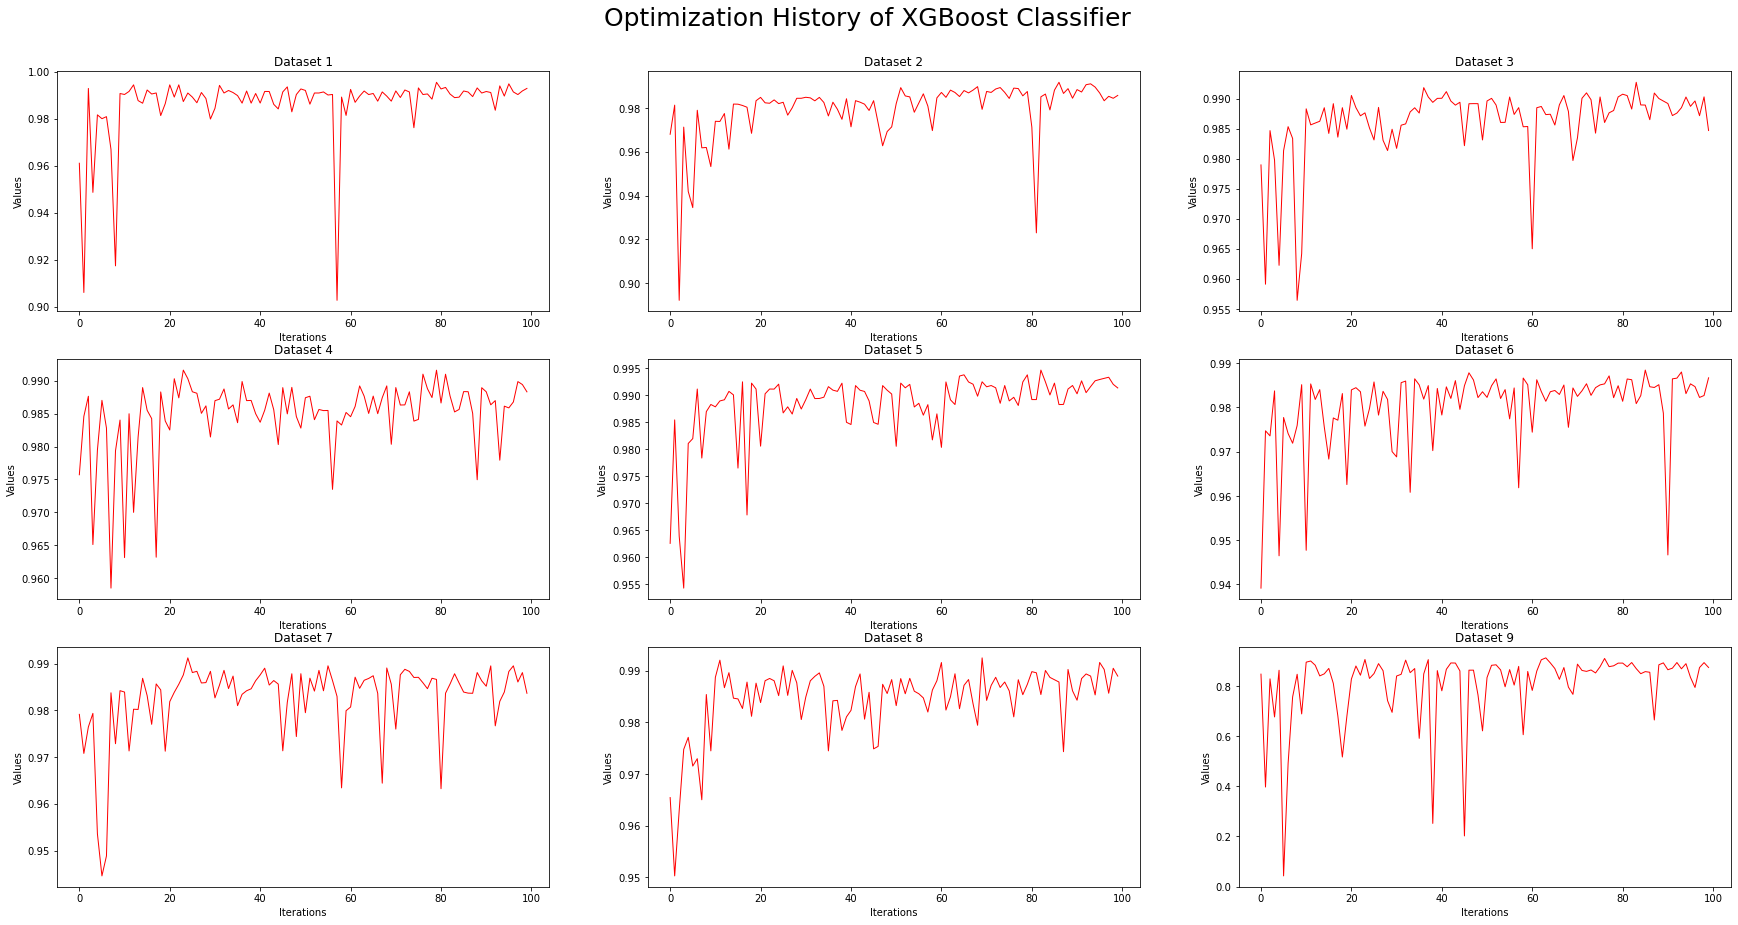

In [34]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'XGBoost Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier

0it [00:00, ?it/s]


 Dataset1:
Precision: 0.0015358361774744026 
Recall: 0.35294117647058826 
Aging Rate: 0.2409093712100968

 Dataset2:
Precision: 0.001088762821614807 
Recall: 0.37254901960784315 
Aging Rate: 0.3587124092992662

 Dataset3:
Precision: 0.0010494180499904598 
Recall: 0.21568627450980393 
Aging Rate: 0.21546177722049786

 Dataset4:
Precision: 0.0012848309644262427 
Recall: 0.3137254901960784 
Aging Rate: 0.2559764846142778

 Dataset5:
Precision: 0.0012342821877651777 
Recall: 0.3137254901960784 
Aging Rate: 0.266459742235195

 Dataset6:
Precision: 0.001033901071992164 
Recall: 0.37254901960784315 
Aging Rate: 0.3777467162737158

 Dataset7:
Precision: 0.0013972985561248254 
Recall: 0.29411764705882354 
Aging Rate: 0.22066229521675676

 Dataset8:
Precision: 0.0015374478365912585 
Recall: 0.27450980392156865 
Aging Rate: 0.1871775370511213

 Dataset9:
Precision: 0.0011024345429490124 
Recall: 0.23529411764705882 
Aging Rate: 0.2237456062817324


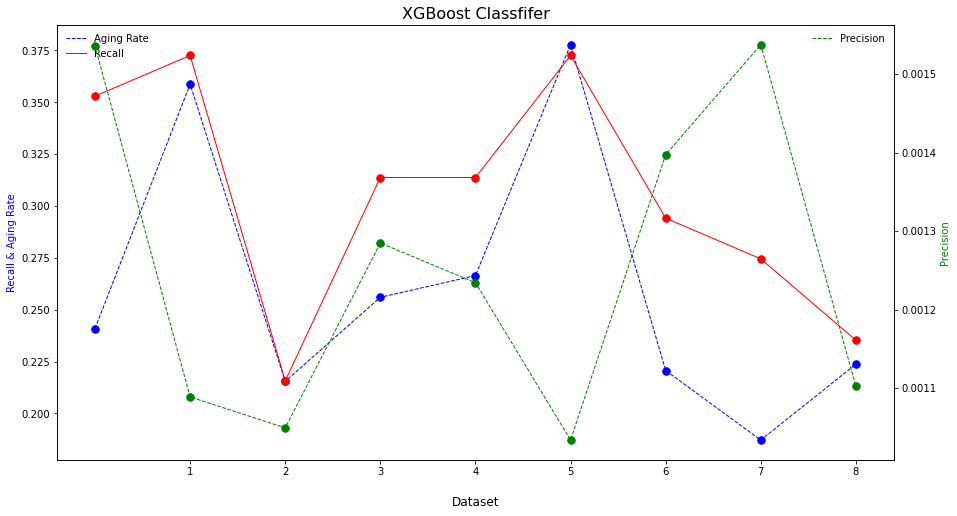

In [35]:
table_setC = runall_XGBoostC(run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'XGBoost Classfifer')

In [36]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,18.0,11702.0,33.0,36896.0,0.001536,0.352941,0.240909,1.465037,0.001529,0.318426
dataset2,1.000000,2999.0,2999.0,19.0,17432.0,32.0,31166.0,0.001089,0.372549,0.358712,1.038573,0.001086,0.265348
dataset3,1.000000,3033.0,3033.0,11.0,10471.0,40.0,38127.0,0.001049,0.215686,0.215462,1.001042,0.001044,0.149615
dataset4,1.000000,3038.0,3038.0,16.0,12437.0,35.0,36161.0,0.001285,0.313725,0.255976,1.225603,0.001280,0.250989
dataset5,1.006623,3040.0,3020.0,16.0,12947.0,35.0,35651.0,0.001234,0.313725,0.266460,1.177384,0.001229,0.244117
dataset6,1.014348,3040.0,2997.0,19.0,18358.0,32.0,30240.0,0.001034,0.372549,0.377747,0.986240,0.001031,0.000000
dataset7,1.099458,3040.0,2765.0,15.0,10720.0,36.0,37878.0,0.001397,0.294118,0.220662,1.332886,0.001391,0.249149
dataset8,1.000000,3040.0,3040.0,14.0,9092.0,37.0,39506.0,0.001537,0.274510,0.187178,1.466575,0.001529,0.247836
dataset9,10.000000,3040.0,304.0,12.0,10873.0,39.0,37725.0,0.001102,0.235294,0.223746,1.051614,0.001097,0.169089


### Regression (optional)

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m5_4selection_XGBoost', 
                                     creator = XGBoost_creator
                                    )

In [ ]:
pr_dict, table_setR = runall_XGBoostR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                       thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'XGBoost Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### Export

In [37]:
savedate = '20220308'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'XGBoost_6'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'XGBoost_6')